In [1]:
from pathlib import Path
import os
import cv2
import numpy as np
import json
from sklearn.model_selection import train_test_split

import sys
sys.path.append("/home/charles/panda/catkin_ws/src/move_chess_panda/scripts")

import matplotlib.pyplot as plt
import shutil

from utili.recap import URI, CfgNode as CN
from chessrec.preprocessing import find_corners, resize_image
from chessrec.preprocessing import gen_occ_data, gen_pie_data

def clean_folder(folder):
    if not os.path.exists(folder):
        os.mkdir(folder)
    else:
        for filename in os.listdir(folder):
            file_path = os.path.join(folder, filename)
            try:
                if os.path.isfile(file_path) or os.path.islink(file_path):
                    os.unlink(file_path)
                elif os.path.isdir(file_path):
                    shutil.rmtree(file_path)
            except Exception as e:
                print(f'Failed to delete {file_path}. Reason: {e}')

def detect_markers(
    frame: np.ndarray,
    show=False,
):  
    gframe = cv2.cvtColor(frame, cv2.COLOR_BGRA2GRAY)
    # detector parameters: https://docs.opencv.org/4.5.3/d1/dcd/structcv_1_1aruco_1_1DetectorParameters.html
    params = cv2.aruco.DetectorParameters_create()
    # rgbframe = cv2.cvtColor(gframe, cv2.COLOR_GRAY2BGR)
    try:
        dictionary = cv2.aruco.Dictionary_get(cv2.aruco.DICT_4X4_50)
    except KeyError:
        raise Exception("indicated marker is not listed in the ARUCO_DICT")

    corners, ids, _ = cv2.aruco.detectMarkers(
        gframe, dictionary=dictionary, parameters=params
    )
    corners = np.array(corners).reshape((-1, 4, 2))
    ids = ids.reshape(-1)
    detected_markers = np.zeros((len(ids),3))
    for i, id in enumerate(ids):
        detected_markers[i, 0] = id
        detected_markers[i, 1:] = np.mean(corners[i], axis=0, dtype=np.int16)
    if show:
        cv2.aruco.drawDetectedMarkers(frame, corners, ids)
        cv2.imwrite("detected.png", frame)
    return corners, ids, detected_markers


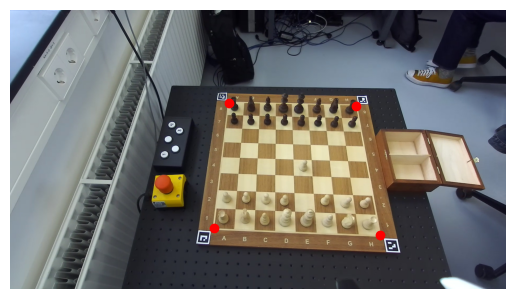

In [9]:
# manual check corners
cam_poses = ["high", "low", "left", "right"]
cam_pose = cam_poses[1]
file_path = Path.home() / Path(f"panda/catkin_ws/src/move_chess_panda/scripts/data/collect/04_08_14_59/img/01_{cam_pose}.png")
corner_detection_cfg = CN.load_yaml_with_base("config://corner_detection.yaml")

img_file = file_path
img = cv2.imread(str(img_file))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
corners = find_corners(corner_detection_cfg, img) 

fig = plt.figure()
plt.imshow(img)
plt.scatter(*corners.T, c="r")
plt.axis("off")
plt.show()

np.savetxt((file_path.parent.parent/ f"corner_{cam_pose}.txt"), corners, delimiter=",")

In [2]:
data_path = Path.home() / "panda/catkin_ws/src/move_chess_panda/scripts/data/to_test"
out_path = Path.home() / "panda/catkin_ws/src/move_chess_panda/scripts/data/to_test_out"
data_count = 0

cam_poses = ["high", "low", "left", "right"]
use_pose = cam_poses[1]
clean_folder(out_path)

for folder in data_path.glob("*/"):
    if len(folder.name) > 5:
        multi_pose = True
    else:
        multi_pose = False
    images = list(Path(folder / "img").glob("*.jpg")) + list(Path(folder / "img").glob("*.png"))
    for img_path in images:
        img_name = img_path.stem
        if multi_pose:
            if img_name[2] == "_": 
                img_count = img_name[:2]
                cam_pose = img_name[3:]
            elif img_name[3] == "_": 
                img_count = img_name[:3]
                cam_pose = img_name[4:]
            if cam_pose not in use_pose:
                # print(f"exclude pose: {cam_pose}")
                continue
        else:
            img_count = img_name
        # deal with image format
        if img_path.suffix == ".jpg":
            img = cv2.imread(str(img_path))
            cv2.imwrite(str(out_path / f"{data_count}.png"), img)
        else:
            shutil.copy(str(img_path), str(out_path / f"{data_count}.png"))
        # update labels
        label_dict = dict()
        label_path = folder / f"label/{img_count}.txt"
        label_dict["white_turn"] = True
        fen = np.genfromtxt(label_path, dtype=str, delimiter=" ")[0]
        label_dict["fen"] = fen.swapcase() if "swapped" in img_path.__str__() else fen
        if multi_pose:
            corner_path = folder / f"corner_{cam_pose}.txt"
        else:
            corner_path = folder / "corner.txt"
        label_dict["corners"] = np.genfromtxt(corner_path, dtype=np.int16, delimiter=",").tolist()
        label_dict["cam_pose"] = cam_pose
        label_dict["cam_pose"] = cam_pose
        json_file = out_path / f"{data_count}.json"
        with json_file.open("w") as f:
            json.dump(label_dict, f)
        data_count += 1


In [4]:
from sklearn.model_selection import train_test_split
import shutil

out_path = Path.home() /"panda/catkin_ws/src/move_chess_panda/scripts/data/to_test_out"
train_val_path = Path.home() / "panda/catkin_ws/src/move_chess_panda/scripts/data/game_test"
is_training = False

clean_folder(train_val_path)
images = out_path.glob("*.png")

if is_training: 
    for subfolder in ["train", "test", "val"]:
        Path(train_val_path / subfolder).mkdir()

    X_train, X_test = train_test_split(range(len(list(images))), test_size=0.1, random_state=42)
    X_train, X_val = train_test_split(X_train, test_size=0.2, random_state=42)
    images = out_path.glob("*.png")
    for i, image in enumerate(images): 
        label = image.parent / (image.stem + ".json")
        if i in X_train:
            shutil.copy(image, train_val_path/"train")
            shutil.copy(label, train_val_path/"train")
        elif i in X_val:
            shutil.copy(image, train_val_path/"val")
            shutil.copy(label, train_val_path/"val")
        elif i in X_test:
            shutil.copy(image, train_val_path/"test")
            shutil.copy(label, train_val_path/"test")
        else:
            print(f"something went wrong... current {i}")
else:
    for subfolder in ["test"]:
        Path(train_val_path / subfolder).mkdir()
    for image in images: 
        label = image.parent / (image.stem + ".json")
        shutil.copy(image, train_val_path/"test")
        shutil.copy(label, train_val_path/"test")

gen_pie_data.create_dataset(train_val_path, train_val_path / "pieces", unique_square=True)
gen_occ_data.create_dataset(train_val_path, train_val_path / "occupancy")

0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 94/94 [00:03<00:00, 25.16it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 94/94 [00:17<00:00,  5.25it/s]


In [41]:
import logging
import typing
import torch

from chessrec.core.training.train import train_model
from chessrec.core import device, DEVICE

logger = logging.getLogger(__name__)

def _train_model(model_type: str) -> typing.Tuple[torch.nn.Module, CN]:
    model_file = next((URI("models://") / model_type).glob("*.pt"))
    yaml_file = URI("config://transfer_learning") / \
        model_type / f"{model_file.stem}.yaml"
    cfg = CN.load_yaml_with_base(yaml_file)
    run_dir = URI("runs://transfer_learning_train_retrainaftermove_v2") / model_type
    model = torch.load(model_file, map_location=DEVICE)
    model = device(model)
    is_inception = "inception" in model_file.stem.lower()
    train_model(cfg, run_dir, model, is_inception,
                model_file.stem, eval_on_train=False)

models = ["piece_classifier"]
# models = ["piece_classifier", "occupancy_classifier"]

for model_type in models:
    logger.info(f"Starting training for {model_type}")
    _train_model(model_type)
    logger.info(f"Finished training for {model_type}")

[2024-03-07 12:03:16,118] {3938509532.py:26} INFO - Starting training for piece_classifier
[2024-03-07 12:03:16,198] {train.py:55} INFO - Starting training in /home/renchi/panda/catkin_ws/src/move_chess_panda/scripts/chess_clf/runs/transfer_learning_train_retrainaftermove_v2/piece_classifier
[2024-03-07 12:03:16,198] {train.py:61} WARNING - The folder /home/renchi/panda/catkin_ws/src/move_chess_panda/scripts/chess_clf/runs/transfer_learning_train_retrainaftermove_v2/piece_classifier already exists and will be overwritten by this run
[2024-03-07 12:03:16,615] {train.py:96} INFO - Step     0 at epoch 0: loss 4.936
[2024-03-07 12:03:28,270] {train.py:96} INFO - Step   100 at epoch 2: loss 2.253
[2024-03-07 12:03:39,864] {train.py:96} INFO - Step   200 at epoch 4: loss 1.678
[2024-03-07 12:03:51,369] {train.py:96} INFO - Step   300 at epoch 6: loss 1.283
[2024-03-07 12:04:02,909] {train.py:96} INFO - Step   400 at epoch 8: loss 1.112
[2024-03-07 12:04:14,422] {train.py:96} INFO - Step   50

In [3]:
from chesscog.recognition.recognition import main
from chesscog.recognition.recognition import ChessRecognizer
import chess

model_path = (URI("runs://transfer_learning_3sides"))
file_path = "/home/renchi/panda/catkin_ws/src/move_chess_panda/scripts/data/from_aurora/02_02_14_43/img/7_left.jpg"

In [2]:
from chessrec.recognizer.recognizer import ChessRecognizer
import chess

model_path = (URI("runs://transfer_learning_3sides_v3"))
file_path = "/home/renchi/panda/catkin_ws/src/move_chess_panda/scripts/data/collect/02_02_14_43/img/08_low.jpg"

In [5]:
img = cv2.imread(file_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

corner_detection_cfg = CN.load_yaml_with_base("config://corner_detection.yaml")

img, img_scale = resize_image(corner_detection_cfg, img)
corners = find_corners(corner_detection_cfg, img)

_, _, markers = detect_markers(img)
print(f"corner: {corners}")
print(f"marker: {markers}")


corner: [[424.13661486 123.20720553]
 [819.44736044 123.59362658]
 [898.18667446 512.9288429 ]
 [347.94318005 508.82038195]]
marker: [[2.000e+00 1.003e+03 5.400e+02]
 [1.000e+00 3.930e+02 5.300e+02]
 [4.000e+00 4.610e+02 1.090e+02]]


In [8]:
recognizer = ChessRecognizer(model_path)
# board, *_ = recognizer.robo_predict(corners, img, chess.WHITE)
board, *_ = recognizer.predict(img, chess.WHITE)

print(board)
print()
# print(
#     f"You can view this position at https://lichess.org/editor/{board.board_fen()}")

if board.status() != chess.Status.VALID:
    print()
    print("WARNING: The predicted chess position is not legal according to the rules of chess.")
    print("         You might want to try again with another picture.")

/home/renchi/miniconda3/envs/torchenv/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/renchi/miniconda3/envs/torchenv/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/renchi/miniconda3/envs/torchenv/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. Y

. r n b . b n r
N p p . . p p p
N . . . . . . .
N . . p . . . .
N . . . P . . .
N . . . . . . .
R P P P . P P P
R R . B K B N R


         You might want to try again with another picture.


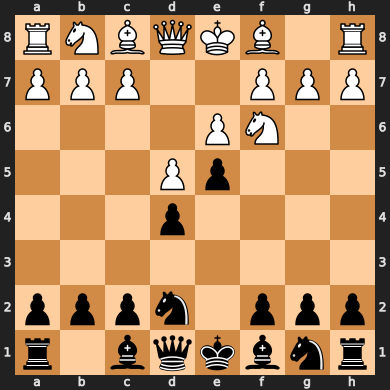

In [71]:
import chess
board = chess.Board(fen="rnbqkb1r/ppp2ppp/4pn2/3pP3/3P4/8/PPPN1PPP/R1BQKBNR")
board.apply_mirror()
board.apply_transform(chess.flip_vertical)
board